## Imports and Dataframe Setup

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy.stats import kurtosis



In [2]:
#Unrefined violent crime, includes some violent crimes that don't have a strong correlation with safety and trust

"""
#CREATING DF FOR VIOLENT CRIME 

import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM ML_VIOLENTCRIME_EDU_INCOME"  #Name of table 

# Create a DataFrame from the SQL query
df_violent = pd.read_sql(query, engine)
"""


'\n#CREATING DF FOR VIOLENT CRIME \n\nimport pandas as pd\nfrom sqlalchemy import create_engine\n\n# Database credentials\nusername = \'crimeadmin\'\npassword = \'4DAnuuSBWVQ92w!F\'\nhost = \'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com\'\ndatabase = \'crimedb_mysql\'\nport = \'3306\'  # default MySQL port\n\n# Create the database engine\nengine = create_engine(f\'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}\')\n\n# SQL query or table name\nquery = "SELECT * FROM ML_VIOLENTCRIME_EDU_INCOME"  #Name of table \n\n# Create a DataFrame from the SQL query\ndf_violent = pd.read_sql(query, engine)\n'

In [3]:

#REFINED DATAFRAME OF VIOLENT CRIME. ONLY INCLUDES ASSAULT, BATTERY, AND HOMICIDE

import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM ML_VIOLENT_REVISED"  #Name of table 

# Create a DataFrame from the SQL query
df_violent = pd.read_sql(query, engine)


#### The refined violent crime dataset slightly improved model performance. Improved R2 scores a few tenths but more significantly improved MSE.

## Evaluating Dataset

In [4]:
df_violent.head()

,Sector,Month,Violent Crimes,SAFETY,S_EDUCATION_LOW,S_EDUCATION_MEDIUM,S_EDUCATION_HIGH,S_INCOME_LOW,S_INCOME_MEDIUM,S_INCOME_HIGH,TRUST,T_EDUCATION_LOW,T_EDUCATION_MEDIUM,T_EDUCATION_HIGH,T_INCOME_LOW,T_INCOME_MEDIUM,T_INCOME_HIGH
0,110,2017-11,66,68.23,NaN,NaN,NaN,NaN,NaN,NaN,65.02,NaN,NaN,NaN,NaN,NaN,NaN
1,110,2017-12,52,65.67,NaN,NaN,NaN,NaN,NaN,NaN,64.76,NaN,NaN,NaN,NaN,NaN,NaN
2,110,2018-01,74,72.35,NaN,NaN,NaN,NaN,NaN,NaN,68.09,NaN,NaN,NaN,NaN,NaN,NaN
3,110,2018-02,73,75.66,NaN,NaN,NaN,NaN,NaN,NaN,70.62,NaN,NaN,NaN,NaN,NaN,NaN
4,110,2018-03,84,73.90,62.18,78.27,74.8,65.28,78.7,73.23,70.81,59.96,71.98,73.84,56.56,74.95,76.14


### Pearson Correlation Analysis
#### Don't see any strong correlations between crimes and the features(Probably why the model isn't performing great) but they are statistically significant

In [5]:
df_excluded = df_violent.drop(columns=['Month'])

# Calculating Pearson correlation coefficients
correlation_matrix = df_excluded.corr()

# Extracting the correlation of each variable with 'Total Crimes'
correlation_with_total_crimes = correlation_matrix['Violent Crimes'].drop('Violent Crimes')

# Displaying the correlation coefficients
print(correlation_with_total_crimes)

Sector               -0.469466
SAFETY               -0.493485
S_EDUCATION_LOW      -0.321082
S_EDUCATION_MEDIUM   -0.419723
S_EDUCATION_HIGH     -0.273574
S_INCOME_LOW         -0.411551
S_INCOME_MEDIUM      -0.395186
S_INCOME_HIGH        -0.236991
TRUST                -0.541519
T_EDUCATION_LOW      -0.448342
T_EDUCATION_MEDIUM   -0.477445
T_EDUCATION_HIGH     -0.352834
T_INCOME_LOW         -0.440544
T_INCOME_MEDIUM      -0.459807
T_INCOME_HIGH        -0.275545
Name: Violent Crimes, dtype: float64


In [6]:

correlation_matrix = df_excluded.corr()
correlation_with_total_crimes = correlation_matrix['Violent Crimes'].drop('Violent Crimes')

# Calculating the significance of each correlation coefficient
n = len(df_excluded)  # sample size
t_values = correlation_with_total_crimes.apply(lambda r: (r * np.sqrt(n - 2)) / np.sqrt(1 - r**2))
p_values = t_values.apply(lambda t: 2 * stats.t.sf(np.abs(t), n - 2))  # two-tailed p-values

# Combining correlation coefficients with their p-values
correlation_significance = pd.DataFrame({
    'Correlation': correlation_with_total_crimes,
    'p-value': p_values
})

# Displaying the results
correlation_significance

,Correlation,p-value
Sector,-0.469466,1.171859e-266
SAFETY,-0.493485,1.184685e-298
S_EDUCATION_LOW,-0.321082,1.096479e-117
S_EDUCATION_MEDIUM,-0.419723,5.039806e-208
S_EDUCATION_HIGH,-0.273574,1.078704e-84
S_INCOME_LOW,-0.411551,2.686979e-199
S_INCOME_MEDIUM,-0.395186,1.540126e-182
S_INCOME_HIGH,-0.236991,2.063651e-63
TRUST,-0.541519,0.000000e+00
T_EDUCATION_LOW,-0.448342,1.467359e-240


### Assessing for unusual data distribution and outliers
#### Not seeing anything too crazy with skewness, slight right skewness with violent crimes, and kurtosis of data that would greatly effect a model
#### We can see there are some outliers with our visualization but probably not effecting the model too significantly

In [7]:

# Drop 'Month' column and any rows with NaN values
df_skew = df_violent.drop(columns=['Month']).dropna()

# Calculate skewness
skewness = df_skew.skew()

# Calculate kurtosis (adding 3 to get regular kurtosis)
kurt = kurtosis(df_skew, fisher=False)

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurt)


Skewness:
 Sector                0.133413
Violent Crimes        0.471711
SAFETY               -0.201261
S_EDUCATION_LOW      -0.268809
S_EDUCATION_MEDIUM   -0.274324
S_EDUCATION_HIGH     -0.310168
S_INCOME_LOW         -0.161373
S_INCOME_MEDIUM      -0.337012
S_INCOME_HIGH        -0.360917
TRUST                 0.080138
T_EDUCATION_LOW       0.043058
T_EDUCATION_MEDIUM   -0.076179
T_EDUCATION_HIGH     -0.234829
T_INCOME_LOW          0.077247
T_INCOME_MEDIUM      -0.007061
T_INCOME_HIGH        -0.212672
dtype: float64

Kurtosis:
 [1.87728203 2.90390687 2.65943383 3.11267531 2.81374184 3.19580271
 2.84692971 2.88082636 3.0275256  2.71403096 2.79520457 2.84936806
 2.90262746 2.83598906 2.76998717 2.85060946]


In [8]:
df = df_violent.drop(['Sector', 'Month'], axis=1)


z_scores = np.abs(stats.zscore(df))
outliers = (z_scores > 3) 

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))



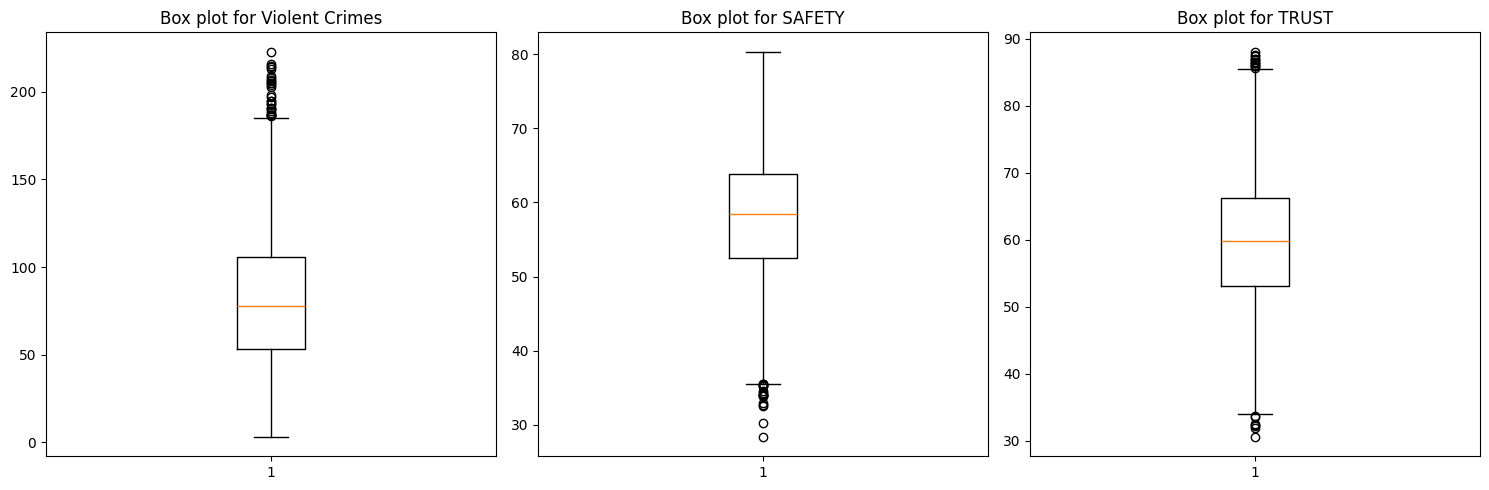

In [9]:

# Select only 'Violent Crimes', 'SAFETY', and 'TRUST' columns
df_selected = df_violent[['Violent Crimes', 'SAFETY', 'TRUST']]

# Create a figure for the box plots
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Create a box plot for each of the selected columns
for i, column in enumerate(df_selected.columns):
    plt.subplot(1, 3, i + 1)  
    plt.boxplot(df_selected[column].dropna())  
    plt.title(f'Box plot for {column}')

plt.tight_layout()
plt.show()


## Prepping for Machine Learing Model

In [10]:
# Converting the 'Month' column to datetime
df_violent['Month'] = pd.to_datetime(df_violent['Month'])


In [11]:
# Selecting numerical columns for standardization
numerical_columns = df_violent.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop(['Sector', 'Violent Crimes'])

# Applying standardization
scaler = StandardScaler()
df_violent[numerical_columns] = scaler.fit_transform(df_violent[numerical_columns])

df_violent.head()

,Sector,Month,Violent Crimes,SAFETY,S_EDUCATION_LOW,S_EDUCATION_MEDIUM,S_EDUCATION_HIGH,S_INCOME_LOW,S_INCOME_MEDIUM,S_INCOME_HIGH,TRUST,T_EDUCATION_LOW,T_EDUCATION_MEDIUM,T_EDUCATION_HIGH,T_INCOME_LOW,T_INCOME_MEDIUM,T_INCOME_HIGH
0,110,2017-11-01,66,1.279775,NaN,NaN,NaN,NaN,NaN,NaN,0.550908,NaN,NaN,NaN,NaN,NaN,NaN
1,110,2017-12-01,52,0.958365,NaN,NaN,NaN,NaN,NaN,NaN,0.523214,NaN,NaN,NaN,NaN,NaN,NaN
2,110,2018-01-01,74,1.797046,NaN,NaN,NaN,NaN,NaN,NaN,0.877906,NaN,NaN,NaN,NaN,NaN,NaN
3,110,2018-02-01,73,2.212620,NaN,NaN,NaN,NaN,NaN,NaN,1.147387,NaN,NaN,NaN,NaN,NaN,NaN
4,110,2018-03-01,84,1.991650,0.645498,2.230172,1.297663,0.891993,2.184311,1.098875,1.167625,0.052758,1.128835,0.840233,-0.027277,1.368428,0.88794


### Creating a new dataframe. Removing months and adding lag features for additional time-series analysis for a regression

In [12]:
#Dropping dates that don't have demographic specific Trust and Safety scores  

df_violent.set_index('Month', inplace=True)

# Filtering the data to include only dates from March 2018 onwards
df_violent_filtered = df_violent[df_violent.index >= '2018-03-01']

In [13]:
#Create lag features 

# Creating 1-month lagged features for numerical columns 
numerical_columns = df_violent_filtered.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col != 'Violent Crimes' and col != 'Sector']

# Creating separate dataframe from copy (to remove warning for using a slice of a copy)
df_violent_filtered_copy = df_violent_filtered.copy()

for column in numerical_columns:
    df_violent_filtered_copy[f'{column}_lag1'] = df_violent_filtered_copy[column].shift(1)

# Dropping the initial row with NaN values due to lagging
df_violent_filtered = df_violent_filtered_copy.dropna()

df_violent_filtered.head()



,Sector,Violent Crimes,SAFETY,S_EDUCATION_LOW,S_EDUCATION_MEDIUM,S_EDUCATION_HIGH,S_INCOME_LOW,S_INCOME_MEDIUM,S_INCOME_HIGH,TRUST,...,S_INCOME_LOW_lag1,S_INCOME_MEDIUM_lag1,S_INCOME_HIGH_lag1,TRUST_lag1,T_EDUCATION_LOW_lag1,T_EDUCATION_MEDIUM_lag1,T_EDUCATION_HIGH_lag1,T_INCOME_LOW_lag1,T_INCOME_MEDIUM_lag1,T_INCOME_HIGH_lag1
Month,,,,,,,,,,,,,,,,,,,,,
2018-04-01,110,64,1.655173,1.144687,1.678584,1.159504,0.494996,2.127500,0.935931,0.897079,...,0.891993,2.184311,1.098875,1.167625,0.052758,1.128835,0.840233,-0.027277,1.368428,0.887940
2018-05-01,110,79,2.105901,1.419731,2.693111,0.813076,0.651208,2.851046,1.368130,0.511497,...,0.494996,2.127500,0.935931,0.897079,-0.171098,0.996959,0.642263,-1.026521,1.473232,0.771547
2018-06-01,110,67,2.120968,1.625279,2.317725,1.060524,1.116859,2.038530,1.656263,0.644640,...,0.651208,2.851046,1.368130,0.511497,-0.283915,0.714106,0.264570,-0.575989,1.089254,-0.010649
2018-07-01,110,91,1.763147,0.857898,1.726739,1.094549,0.890003,1.409313,1.460531,1.015310,...,1.116859,2.038530,1.656263,0.644640,0.079407,0.916923,-0.273689,0.495743,-0.209043,0.548626
2018-08-01,110,96,1.927619,1.209288,1.649035,1.675022,0.981541,1.282827,1.442647,1.385979,...,0.890003,1.409313,1.460531,1.015310,0.963282,1.006053,0.180638,1.180258,0.162286,0.900763


In [14]:
df_violent_filtered.columns


Index(['Sector', 'Violent Crimes', 'SAFETY', 'S_EDUCATION_LOW',
       'S_EDUCATION_MEDIUM', 'S_EDUCATION_HIGH', 'S_INCOME_LOW',
       'S_INCOME_MEDIUM', 'S_INCOME_HIGH', 'TRUST', 'T_EDUCATION_LOW',
       'T_EDUCATION_MEDIUM', 'T_EDUCATION_HIGH', 'T_INCOME_LOW',
       'T_INCOME_MEDIUM', 'T_INCOME_HIGH', 'SAFETY_lag1',
       'S_EDUCATION_LOW_lag1', 'S_EDUCATION_MEDIUM_lag1',
       'S_EDUCATION_HIGH_lag1', 'S_INCOME_LOW_lag1', 'S_INCOME_MEDIUM_lag1',
       'S_INCOME_HIGH_lag1', 'TRUST_lag1', 'T_EDUCATION_LOW_lag1',
       'T_EDUCATION_MEDIUM_lag1', 'T_EDUCATION_HIGH_lag1', 'T_INCOME_LOW_lag1',
       'T_INCOME_MEDIUM_lag1', 'T_INCOME_HIGH_lag1'],
      dtype='object')

### Creating training and testing data splits

In [15]:
#Splitting into training and testing data


# Separating features and target variable
X = df_violent_filtered.drop(['Violent Crimes', 'Sector'], axis=1)
y = df_violent_filtered['Violent Crimes']

# Splitting the dataset into training and testing sets 
split_idx = int(len(df_violent_filtered) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]




In [16]:
#Code to see what happens when allowing sector (ie. location) be a feature

"""
#Splitting into training and testing data

# Separating features and target variable
X = df_violent_filtered.drop(['Violent Crimes'], axis=1)
y = df_violent_filtered['Violent Crimes']

# Splitting the dataset into training and testing sets 
split_idx = int(len(df_violent_filtered) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
"""


"\n#Splitting into training and testing data\n\n# Separating features and target variable\nX = df_violent_filtered.drop(['Violent Crimes'], axis=1)\ny = df_violent_filtered['Violent Crimes']\n\n# Splitting the dataset into training and testing sets \nsplit_idx = int(len(df_violent_filtered) * 0.8)\nX_train, X_test = X[:split_idx], X[split_idx:]\ny_train, y_test = y[:split_idx], y[split_idx:]\n"

### Quick aside about feature selection consideration
#### When using 'Sector' as a feature, the R2 values for random forest and gradient boosting are much higher, .77 for random forest. This makes sense because some areas are inevitably more associated with crime due to other variables not captured in the dataset like socioeconomic factors (poverty, education, etc.). Including sectors as a feature adds this potential component but not directly. Also has the issue of introducing potential bias so I'm not sure if including it is the best option. 

#### Scores with Sector included in features:
##### Random Forest': {'MAE': 12.564918918918918,'MSE': 265.5884502702703,'RMSE': 16.296884679909542,'R2': 0.7819728805980152},
#### Without: 
##### 'Random Forest': {'MAE': 22.904994594594598,'MSE': 815.274611027027,'RMSE': 28.553014044528243,'R2': 0.3307240025576754},

## Creating Regression Models

In [17]:

# Initializing the Linear Regression model
lr_model = LinearRegression()

# Training the model on the training set
lr_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
mae, mse, rmse, r2


(23.54232760180375, 856.6913837604721, 29.26929079701919, 0.29672410668565785)

### Looking at other models

In [18]:
#Iterating through dictionary of different models, creating a model from data splits, and generating scores for each

# Initializing the models
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()
svr_model = SVR()
ridge_model = Ridge()
lasso_model = Lasso()
elastic_net_model = ElasticNet()

# Dictionary to store models and their predictions
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Support Vector Regression": svr_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_model,
    "Elastic Net": elastic_net_model
}

# Dictionary to store evaluation metrics
model_metrics = {}

# Training each model and evaluating
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    model_metrics[model_name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

# Displaying the evaluation metrics for each model
model_metrics



{'Random Forest': {'MAE': 22.870583783783786,
  'MSE': 822.9804513513513,
  'RMSE': 28.687635862011206,
  'R2': 0.3243981168997171},
 'Gradient Boosting': {'MAE': 23.308638095219994,
  'MSE': 843.3601804994852,
  'RMSE': 29.040664257201232,
  'R2': 0.3076679705554817},
 'Support Vector Regression': {'MAE': 22.95685703767503,
  'MSE': 844.3878978731631,
  'RMSE': 29.05835332349655,
  'R2': 0.30682429584630544},
 'Ridge Regression': {'MAE': 23.54121583686677,
  'MSE': 856.605006592194,
  'RMSE': 29.267815200185236,
  'R2': 0.29679501551155985},
 'Lasso Regression': {'MAE': 23.824668030954438,
  'MSE': 867.6050363690333,
  'RMSE': 29.455135993049385,
  'R2': 0.28776486076221075},
 'Elastic Net': {'MAE': 23.97332883124973,
  'MSE': 876.1171855135625,
  'RMSE': 29.599276773488274,
  'R2': 0.2807770593122111}}

### Random Forest the best performing model. Let's proceed with this model

In [19]:
# Initializing the Random Forest regressor
rf_model = RandomForestRegressor()

# Training the model on the training set
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
mae, mse, rmse, r2


(23.01737297297297, 825.6369116756758, 28.7338983028004, 0.3222173730016721)

## Analysis:
#### We probably need more features for this model. This poses a challenge, however, because none of the other data we have fits into these time frames and instead are static periods in time, often times many years ago

### CREATING DATAFRAME FOR OUR MAIN DATASET FOR INSPECTION

In [20]:
#Will take ahile to run. Add and remove docstrings as needed 

import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM Chicago_Crime_Main"  #Name of table 

# Create a DataFrame from the SQL query
df_crime_main = pd.read_sql(query, engine)

df_crime_main.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,5741943,HN549294,2007-08-25 09:22:18,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,0,0,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1930689,HH109118,2002-01-05 21:24:00,007XX E 103 ST,0820,THEFT,$500 AND UNDER,GAS STATION,1,0,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13203321,JG415333,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),0,0,...,-87.633938,"(41.886018055, -87.633937881)",22.0,14309.0,38.0,92.0,36.0,46.0,22.0,79.0
3,13210088,JG423627,2023-08-31 12:00:00,023XX W JACKSON BLVD,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,STREET,0,0,...,-87.684791,"(41.877565108, -87.68479102)",48.0,21184.0,29.0,766.0,46.0,28.0,15.0,139.0
4,13210004,JG422532,2023-07-24 21:45:00,073XX S JEFFERY BLVD,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,0,0,...,-87.576209,"(41.7619185, -87.576209245)",32.0,22538.0,39.0,419.0,37.0,24.0,18.0,89.0
5,13210062,JG423596,2023-08-27 07:00:00,034XX N LAWNDALE AVE,0820,THEFT,$500 AND UNDER,APARTMENT,0,0,...,-87.719974,"(41.943378528, -87.7199738)",27.0,21538.0,22.0,138.0,21.0,39.0,1.0,20.0
6,13210107,JG411849,2023-09-04 21:30:00,053XX S HOMAN AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE - GARAGE,0,0,...,-87.708541,"(41.796477414, -87.708540915)",49.0,22248.0,61.0,776.0,8.0,56.0,13.0,129.0
7,13210060,JG423567,2023-08-15 14:20:00,077XX S SPAULDING AVE,0810,THEFT,OVER $500,RESIDENCE - PORCH / HALLWAY,0,0,...,-87.704909,"(41.752688801, -87.704908791)",6.0,4300.0,69.0,498.0,30.0,8.0,13.0,226.0
8,13210120,JG423499,2023-07-24 16:09:00,002XX W 75TH ST,1120,DECEPTIVE PRACTICE,FORGERY,CURRENCY EXCHANGE,0,0,...,-87.631583,"(41.758126171, -87.631582508)",17.0,21554.0,67.0,494.0,32.0,11.0,17.0,210.0
9,13210071,JG421086,2023-09-03 10:27:00,089XX S LOOMIS ST,0890,THEFT,FROM BUILDING,APARTMENT,0,0,...,-87.658075,"(41.731497731, -87.658074565)",18.0,21554.0,72.0,195.0,13.0,59.0,9.0,244.0


### Inspecting other data sets we have

In [21]:
#INFO ON DATASET:
#Published in 2014 using data from 2008-2012. Data is by community area which is a different granularity to our current data which is by police
#sector and doesn't have specific location coordinates to easily convert 

import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM Cleaned_Census_Data"  #Name of table 

# Create a DataFrame from the SQL query
df_census = pd.read_sql(query, engine)

In [22]:
df_census.head(5)

,id,Community_Area_Number,COMMUNITY_AREA_NAME,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16_UNEMPLOYED,PERCENT_AGED_25_WITHOUT_HIGH_SCHOOL_DIPLOMA,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX
0,1,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6


In [23]:
#INFO ON DATASET:
#Affordable rental housing developments since 2013 that is updated periodically, last updated this month. No specific dates on  these, however.
#Only roughly 580 rows so not a lot of data, could use number of units per location, however. 

import pandas as pd
from sqlalchemy import create_engine

# Database credentials
username = 'crimeadmin'
password = '4DAnuuSBWVQ92w!F'
host = 'crimedbmysql.cspoouh9lugd.us-east-2.rds.amazonaws.com'
database = 'crimedb_mysql'
port = '3306'  # default MySQL port

# Create the database engine
engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')

# SQL query or table name
query = "SELECT * FROM Cleaned_Housing_Developments"  #Name of table 

# Create a DataFrame from the SQL query
df_housing = pd.read_sql(query, engine)

In [24]:
df_housing.head(5)

,id,Community_Area_Name,Community_Area_Number,Property_Type,Property_Name,ADDRESS,ZIP_CODE,Phone_Number,Management_Company,Units,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,1,Near West Side,28,ARO,The Dylan,160 N. Morgan St.,60607,872.328.0028,Sterling Bay,28,1169706.814,1901381.768,41.88489541,-87.65226488,"(41.884895408116236, -87.65226488412628)"
1,2,Hegewisch,55,Senior,Senior Suites of Hegewisch,13550 S. Avenue O,60633,773-646-1333,Senior Lifestyle Corp.,116,1201038.059,1815487.733,41.64845741,-87.54012317,"(41.648457411436, -87.5401231660406)"
2,3,Uptown,3,Senior,Wilson Yard Senior Apts.,1032 W. Montrose Ave,60613,866-227-0438,Holsten Real Estate Dev. Corp.,13,1168438.959,1929421.65,41.96186585,-87.65610743,"(41.9618658532981, -87.656107428372)"
3,4,Lake View,6,ARO,The Mode,3462 N. Lincoln Ave.,60657,773-205-8300,606 Realty,2,1164033.827,1923207.502,41.94490833,-87.67247934,"(41.9449083304908, -87.6724793376448)"
4,5,North Lawndale,29,Multifamily,Lawndale Restoration II Apts. (scattered sites),10 N. Hamlin Ave.,60613,312-337-5339,Holsten Management Corp.,170,1151024.342,1899855.056,41.88109233,-87.72091009,"(41.8810923305496, -87.7209100899284)"


### Other datasets available:

#### Data on bus and train ridership numbers by month. Fits into our monthly time frames. Would have to be adjusted per capita of population probably. Have census population data updated in 2019 for each census block/tract. Would have to convert locations

#### Data from 2020 on open and closed grocery stores. Could be used to assess food deserts

## Crime Forecasts/Prediction